In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit

# Towards a Kinetic Ising Model

In this notebook, we try to devise a dynamical version of the Ising model. The goal is to extract some temporal features from this model, which are not present in the original Ising model. While different approaches to making a dynamical Ising model exist, our starting point is the work by Keegstra et al. In short, this approach consists of a Gillespie simulation of spin flips, where the rate at which each spin flips depends on its nearest neighbours through the hamiltonian. 

For this purpose, we first consider general steps in our approach, which consists of setting up a master equation, from which detailed balance helps specify the rates of spin-flipping. We then apply this strategy to the 1D Ising model to see whether it agrees with the original Ising model and to explore what kind of temporal statistics we could look for. These ideas are then extended to a 2D Ising model, which will hopefully bring us closer to a model for the chemotactic receptor clusters in *E. coli*.

## Master Equation and Detailed Balance

In this section, we write down the master equation for the Ising model and apply detailed balance to specify the rates at which spins flip. Let $\mathbf{s}$ denote the state vector, which consists of spins $s_1,...,s_N$, all of which are $-1$ or $1$. We seek to find the probability $p(\mathbf{s}, t)$ that the system is in state $\mathbf{s}$ at time $t$. We consider a time step $\partial t$ so short that one and only one spin flips within $\partial t$. We use $\mathbf{s}_{-i}$ to denote the state where only the $i$th spin in $\mathbf{s}$ has flipped. 

In order to write down the master equation, realise that only two things are relevant. Either, we start in state $\mathbf{s}$ and leave it because any spin flips, or we start in some other state $\mathbf{s}_{-i}$ and flip the $i$th spin to reach $\mathbf{s}$. From this, we can write down the master equation as

$$ \frac{\partial p(\mathbf{s},t)}{\partial t} = \sum_{i=1}^N \omega(-s_i \rightarrow s_i) p(\mathbf{s}_{-i}, t) - \sum_{i=1}^N \omega(s_i \rightarrow -s_i) p(\mathbf{s}, t). $$

Note that we could take $p(\mathbf{s}, t)$ in front of the summation, since it does not depend on $i$. Here, we use $\omega(s_i \rightarrow -s_i)$ to denote the rate of flipping $s_i$. It is hard to solve the master equation in general, but we can insist that equilibrium is reached when $\partial p(\mathbf{s},t)/\partial t = 0$, such that

$$\sum_{i=1}^N \omega(-s_i \rightarrow s_i) p(\mathbf{s}_{-i}) = \sum_{i=1}^N \omega(s_i \rightarrow -s_i) p(\mathbf{s}).$$

We have removed the time dependence in the probabilities, because we only insist this relation to hold in equilibrium. The question is then how we should specify the rates, such that this relation is satisfied. A sufficient (but not necessary!) way to satisfy this is by comparing the sums term by term, which gives rise to **detailed balance**, which states that 

$$\omega(-s_i \rightarrow s_i) p(\mathbf{s}_{-i}) = \omega(s_i \rightarrow -s_i) p(\mathbf{s}).$$

While this already puts some constraints on the rates, we should specify the equilibrium distribution to be more concrete. Fortunately, we can employ the Boltzmann distribution, so if the hamiltonian is $\mathcal{H}(\mathbf{s})$, then 

$$ p(\mathbf{s}) = \frac{1}{\mathcal{Z}}\exp\{-\mathcal{H}(\mathbf{s})\},$$

with the partition function defined by 

$$ \mathcal{Z} \equiv \sum_{\mathbf{s}} \exp\{-\mathcal{H}(\textbf{s})\}. $$

Note that we have chosen units such that $k_\text{B} T = 1$. With this result at hand, we can rewrite detailed balance as

$$\frac{\omega(s_i \rightarrow -s_i)}{\omega(-s_i \rightarrow s_i)} = \frac{p(\mathbf{s}_{-i})}{p(\mathbf{s})} = \exp\{-\Delta \mathcal{H}(\mathbf{s},i)\}, $$

where $\Delta \mathcal{H}(\mathbf{s},i) \equiv \mathcal{H}(\mathbf{s}_{-i}) - \mathcal{H}(\mathbf{s})$. This places a concrete form that the ratio of flipping rates should have. While many solutions are in principle possible, a natural choice is

$$\omega(s_i \rightarrow -s_i) = \omega_0 \exp\left\{-\frac{1}{2}\Delta \mathcal{H}(\mathbf{s},i)\right\}, $$

which closely follows the line of reasoning by Keegstra et al. This choice satisfies detailed balance since $\Delta\mathcal{H}(\mathbf{s}_{-i},i) = -\Delta \mathcal{H}(\mathbf{s},i)$, so

$$\frac{\omega(s_i \rightarrow -s_i)}{\omega(-s_i \rightarrow s_i)} =  \frac{\omega_0 \exp\left\{-\frac{1}{2}\Delta \mathcal{H}(\mathbf{s},i)\right\}}{\omega_0 \exp\left\{-\frac{1}{2}\Delta \mathcal{H}(\mathbf{s}_{-i},i)\right\}} = \frac{\exp\left\{-\frac{1}{2}\Delta \mathcal{H}(\mathbf{s},i)\right\}}{\exp\left\{\frac{1}{2}\Delta \mathcal{H}(\mathbf{s},i)\right\}} = \exp\{-\Delta\mathcal{H}(\mathbf{s},i)\},$$

as desired. Note that this choice for the flipping rates introduces a new parameter $\omega_0$, which is the rate for a spin flip that does not change the energy of the system. As such, this parameter sets the typical time scale of spin flips. Throughout the simulation, we set $\omega_0 = 1$ for convenience. 

## Simulating the Ising Model

Several methods for simulating the Ising model exist, but in many cases, the time scale in such simulations does not necessarily represent any real physical features of the system. For example, the experimenter can choose a timestep (typically in the order of $1/N$) and flips a spin at each time step. However, this fails to capture the actual time evolution of the system. For instance, it seems intuitive that spins flip at a slower rate if the system is closer to an equilibrium. Therefore, we aim for a simulation that captures such temporal features of the Ising model. 

Concretely, we will focus on two schemes. Firstly, we will try to implement Gillespie's direct algorithm, because we have a closed form expression for the different rates. Secondly, we try Glauber dynamics, which is close to the approach by Keegstra et al. We apply both approaches to a one- and two-dimensional Ising model. Throughout this work, we make the following assumptions about the Ising models:

- each spin only takes values $\pm 1$;
- the spins are arranged in a regular lattice;
- spins only interact with their nearest neighbours;
- the coupling constant and external field are identical for all spins.

Under these assumptions, the hamiltonian for the Ising model becomes

$$\mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j - H \sum_{i=1}^N s_i,$$

where $(i,j)$ denotes that $i$ and $j$ are chosen such that they are nearest neighbours. Previously, we derived that the flipping rate depends on the energy difference between the initial state and the state containing the flipped spin. This energy difference is straightforward to calculate, since flipping spin $s_i$ only affects those term in the hamiltonian that contain $s_i$, such that we can find

$$ \Delta \mathcal{H}(\mathbf{s},i) = 2\left[J s_i \sum_{(i,j)}s_j + H s_i \right]. $$

Note that $s_i$ can be taken out of the first sum, because we are not summing over $i$, but rather only over those $j$ that are nearest neighbours to $i$. This result makes calculating the energy difference computationally cheaper, since it involves only a few terms, rather than having to compute two full-fledged hamiltonians and subtracting them. 

# Gillespie's Direct Algorithm

We now proceed to implementing the Ising model using Gillespie's direct algorithm. This is a stochastic discrete event-based approach to simulate a series of reactions or -- in this case -- spin flips. The algorithm relies heavily on the rates at which the reactions take place, since these rates determine the time until the next reaction occurs as well as which event takes place. Concretely, the algorithm consists of the following steps, where we use the shorthand $\omega_i \equiv \omega(s_i \rightarrow -s_i)$:

- compute the total rate of flipping a spin $\Omega = \sum_{i=1}^N \omega_i$;
- sample the time until the next event occurs as d$t = -\log(u_1)/\Omega$, where $u\sim$ Uniform$(0,1)$;
- draw $u_2 \sim$ Uniform$(0,1)$, set $P = u_2 \Omega$ and flip spin $p$ where $p$ satisfies

$$ \sum_{i=1}^{p-1}\omega_i \leq P \leq \sum_{i=1}^{p} \omega_i; $$

- update time $t \rightarrow t + \text{d}t$ and repeat.

Importantly, time is a random variable in this algorithm and depends on the rates, such that we expect to capture some temporal statistics about the Ising model using this algorithm. 

**Problem**: is it possible to find a closed form expression for $\Omega$?

**Problem**: for things like average magnetisation per spin, should I take an ensemble average over multiple realisations?

## 1D Ising Model

We start the simulation with a 1D Ising model with periodic boundary conditions. In this case, the hamiltonian becomes

$$ \mathcal{H}(\mathbf{s}) = -J \sum_{i=1}^Ns_i s_{i+1} - H\sum_{i=1}^N s_i, $$

where the periodic boundary means that $s_{N+1} = s_1$. The flipping rate then takes the form

$$\omega_i = \omega_0 \exp\{-J( s_{i-1}s_i + s_is_{i+1}) - H s_i\}. $$

In [2]:
@numba.jit(nopython=True)

# define a function for finding all the flipping rates
def rates_1d(state,J,H,omega0=1):
    coupling = -J*(state*np.roll(state,-1) + state*np.roll(state,1))
    external = -H*state
    return omega0*np.exp(coupling+external)

In [3]:
@numba.jit(nopython=True)

def gillespie_ising_1d(n_sims,N,J,H):
    # initialise randomly
    state = np.random.choice(np.array([-1.,1.]), N)

    # array to store all results
    all_states = np.zeros((n_sims,N))
    all_states[0,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)

    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # obtain rates of flipping
        rates = rates_1d(state,J,H)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt

        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]

        # flip the state and save it
        state[i] *= -1
        all_states[k,:] = state
        
    return all_states, waiting_times

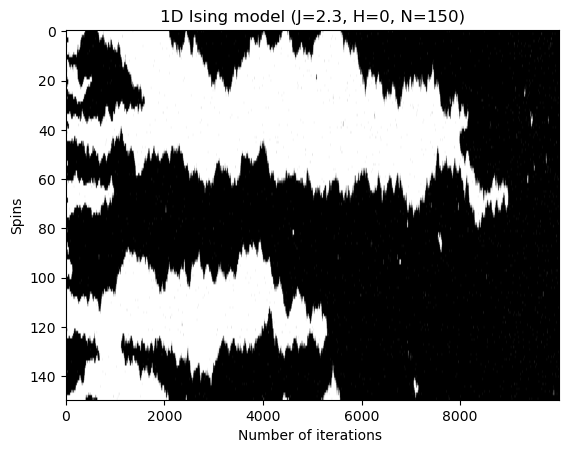

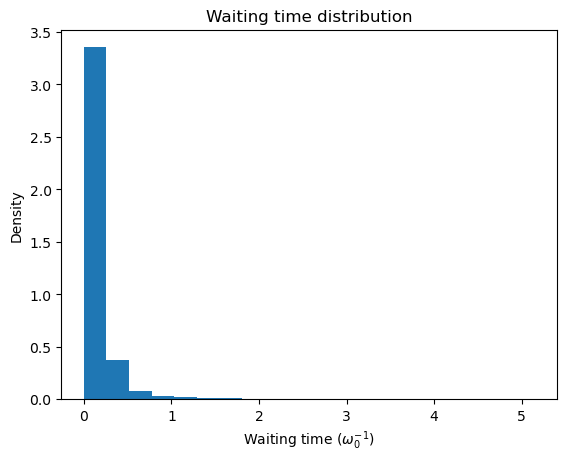

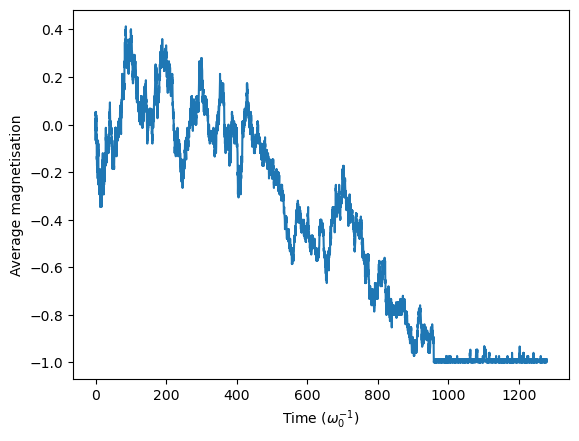

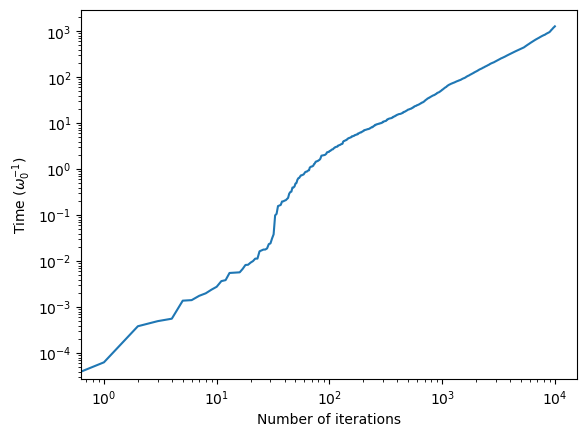

In [4]:
# parameters
n_sims = 10**4
N = 150
J = 2.3
H = 0

all_states, waiting_times = gillespie_ising_1d(n_sims,N,J,H)

# show the results per iteration    
plt.imshow(all_states.T, cmap=plt.cm.gray,aspect=50)
plt.xlabel('Number of iterations ')
plt.ylabel('Spins')
plt.title(f'1D Ising model (J={J}, H={H}, N={N})')
plt.show()

# show histogram of the waiting times
plt.hist(waiting_times,density='True',bins=20)
plt.xlabel(r'Waiting time ($\omega_0^{-1}$)')
plt.ylabel('Density')
plt.title('Waiting time distribution')
plt.show()

# show average magnetisation over time
magnetisation = np.mean(all_states,axis=1)
time = np.cumsum(waiting_times)

plt.plot(time, magnetisation)
plt.xlabel(r'Time ($\omega_0^{-1}$)')
plt.ylabel('Average magnetisation')
plt.show()

# show time versus the number of iterations
plt.loglog(np.arange(n_sims), time)
plt.xlabel('Number of iterations')
plt.ylabel(r'Time ($\omega_0^{-1}$)')
plt.show()

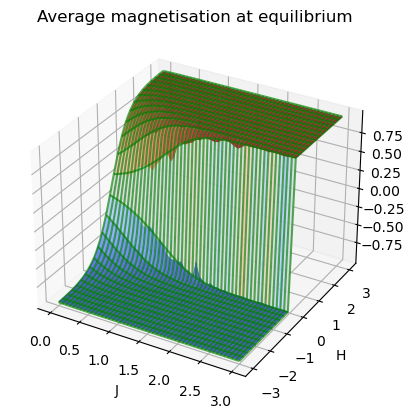

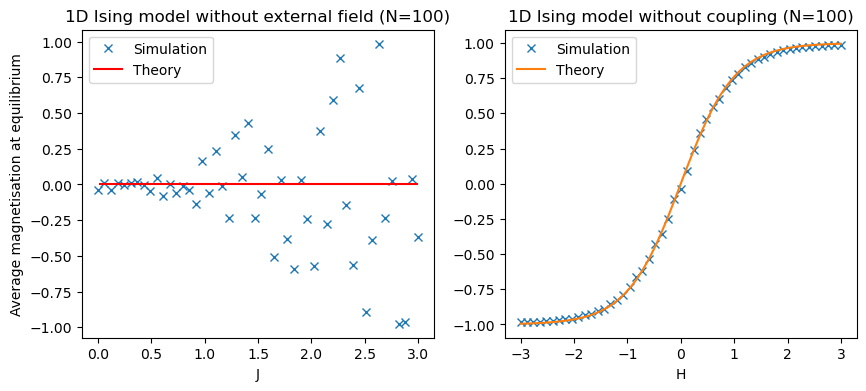

In [5]:
# initialise and parameters
n_sims = 5*10**3
N = 100

# values to loop over
J_arr = np.linspace(0,3,50)
H_arr = np.linspace(-3,3,51)

J_plot, H_plot = np.meshgrid(J_arr,H_arr)
exact = np.sinh(H_plot)/(np.sqrt(np.sinh(H_plot)**2 + np.exp(-4*J_plot)))

# store results
all_avg_act = np.zeros((J_arr.size,H_arr.size))

# perform Gillespie for various J and H
for i,J in enumerate(J_arr):
    for j,H in enumerate(H_arr):
        all_states, waiting_times = gillespie_ising_1d(n_sims,N,J,H)
        avg_act = np.mean(all_states, axis=1)
    
        # truncate after one third of the simulation
        all_avg_act[i,j] = np.mean(avg_act[n_sims//3:])
        
# show results
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(J_plot.T, H_plot.T, all_avg_act,cmap=plt.cm.coolwarm,alpha=0.9,label='Simulation')
ax.plot_wireframe(J_plot, H_plot, exact, color='g',alpha=0.65,label='Theory')
ax.set_xlabel('J')
ax.set_ylabel('H')
ax.set_title('Average magnetisation at equilibrium')
plt.show()

# specific cases
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# plot average magnetisation as a function of J where H = 0
H0_idx = np.where(H_arr==0)[0][0]
ax1.plot(J_arr,all_avg_act[:,H0_idx],'x',label='Simulation')
ax1.axhline(y=0,xmin=0.05,xmax=0.95,color='r',label='Theory')
ax1.set_xlabel('J')
ax1.set_ylabel('Average magnetisation at equilibrium')
ax1.set_title(f'1D Ising model without external field (N={N})')
ax1.legend()

# case without coupling energy
ax2.plot(H_arr,all_avg_act[0,:],'x',label='Simulation')
ax2.plot(H_arr,np.tanh(H_arr),label='Theory')
ax2.set_title(f'1D Ising model without coupling (N={N})')
ax2.legend()
ax2.set_xlabel('H')

plt.show()

## 2D Ising Model

We now move on to the 2D Ising model with open boundary conditions. The structure of the model is an $L\times L$ regular lattice of $N=L^2$ spins. The open boundary means that the spins at the border and at the corners of the lattice miss one or two neighbours, respectively. The hamiltonian becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j - H \sum_{i=1}^N s_i. $$

In this case, the flipping rate is

$$ \omega_i = \omega_0 \exp\left\{-J s_i \sum_{(i,j)}s_j - H s_i\right\}. $$

This is less straightforward to implement than the 1D case, especially because of the open boundary condition. The reason is that the number of neighbours differs depending on whether a spin sits in the bulk (four neighbours), on the edge (three neighbours) or corner (two neighbours) of the lattice. Additionally, whether the neighbours sit the left or right and up or down also depends on the position of the spin. This makes the code a bit inelegant, but still, the sum involving the coupling constant contains at most four terms, which makes computing the rates feasible. 

In [6]:
# this function determines the coupling energy based on the location of the spin
def rates_2d(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left_neighbours = np.roll(state,(0,1),axis=(0,1))
    left_neighbours[:,0] = 0
    
    right_neighbours = np.roll(state,(0,-1),axis=(0,1))
    right_neighbours[:,-1] = 0
    
    top_neighbours = np.roll(state,(1,0),axis=(0,1))
    top_neighbours[0,:] = 0
    
    bottom_neighbours = np.roll(state,(-1,0),axis=(0,1))
    bottom_neighbours[-1,:] = 0
    
    # compute coupling summation for each spin
    coupling = J*state*(left_neighbours + right_neighbours + top_neighbours + bottom_neighbours)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

In [7]:
L = 10
state = np.random.choice([-1.,1.], L**2)
state = state.reshape((L,L))
J = 1
H = 1

%timeit rates_2d(J,H,state)

50.4 µs ± 383 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
def gillespie_ising_2d(n_sims,L,J,H):
    # initialise randomly
    state = np.random.choice([-1.,1.], L**2)
    state = state.reshape((L,L))

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)

    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # obtain rates of flipping
        rates = rates_2d(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt

        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

In [9]:
n_sims = 10**2
L = 10
J = 1
H = 1

%timeit gillespie_ising_2d(n_sims,L,J,H)

9.13 ms ± 42.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


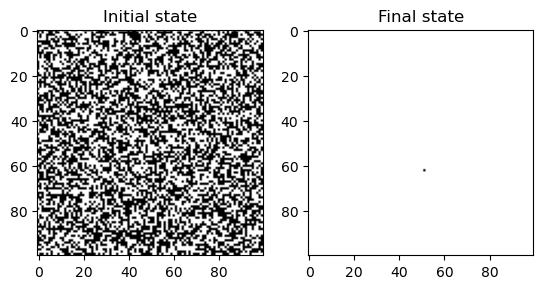

In [10]:
# this checks whether the algorithm works
n_sims = 10**4
L = 100
J = 1
H = 1

spins, waiting_times = gillespie_ising_2d(n_sims,L,J,H)

# show first and final state
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(spins[0,:,:], cmap=plt.cm.gray)
ax1.set_title('Initial state')

ax2.imshow(spins[-1,:,:], cmap=plt.cm.gray)
ax2.set_title('Final state')

plt.show()

We observe that starting from a fully disordered state, the system converges towards a state where all spins align, which verifies that our implementation is correct!

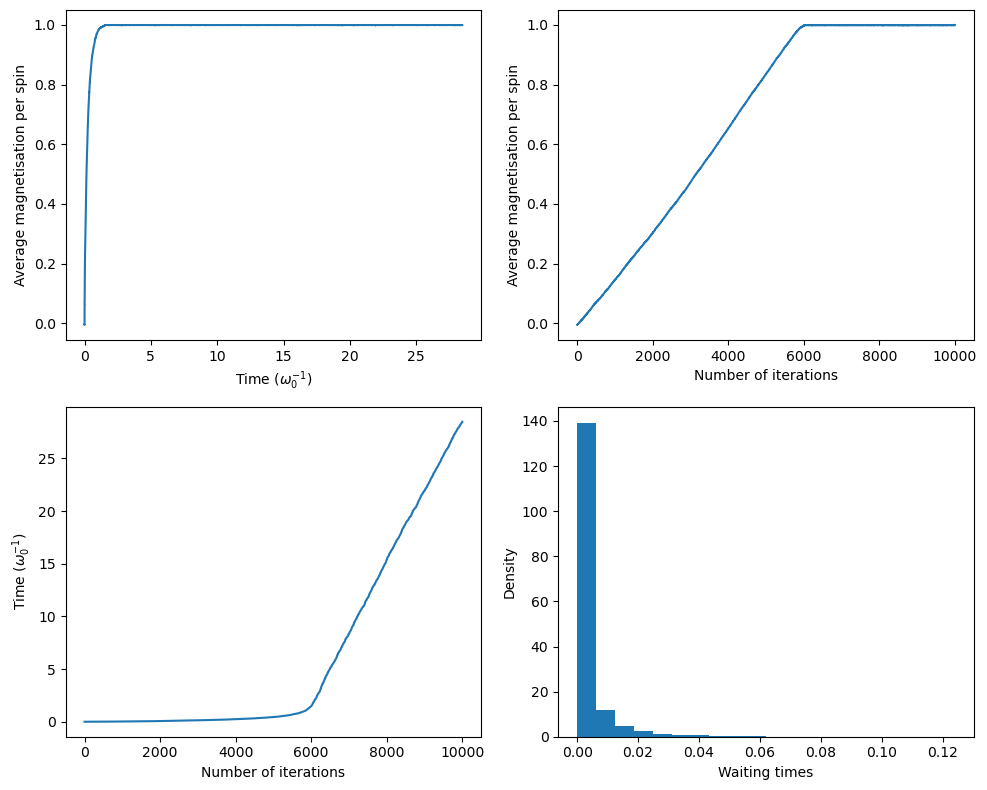

In [11]:
# average magnetisation

avg_spin = np.mean(spins, axis=(1,2))
time = np.cumsum(waiting_times)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

ax1.plot(time, avg_spin)
ax1.set_xlabel(r'Time $(\omega_0^{-1})$')
ax1.set_ylabel('Average magnetisation per spin')

ax2.plot(np.arange(n_sims), avg_spin)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Average magnetisation per spin')

ax3.plot(np.arange(n_sims), time)
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel(r'Time $(\omega_0^{-1})$')

ax4.hist(waiting_times, density=True, bins=20)
ax4.set_xlabel('Waiting times')
ax4.set_ylabel('Density')

plt.tight_layout()

plt.show()

These plots show that the system rapidly approaches an equilibrium where the average magnetisation hardly changes. Moreover, these plots explicitly show that the number of iterations is not a good measure for the physical time scale of the system, because the plots indicate that the first few spins flip very fast. This makes sense, because the system is out of equilibrium but approaches it fast. Once it has reached this equilibrium, spins flip at a much lower rate, such that the time step between iterations increases and settles to a roughly constant value.

### Comparison to Theory

The above results on the temporal statistics are intuitive, but we would like to verify that our simulation correctly implements the Ising model. For this purpose, we compare the magnetisation per spin at equilibrium to the theoretical result. We do so for two cases: without coupling $(J=0)$ and without an external field $(H=0)$. For the first case, the average magnetisation $m$ is expected to depend on $H$ as 

$$ m = \tanh(H). $$

In the case without coupling, a well-known property of the 2D Ising model is that it displays a continuous phase transition between ferro- and paramagnetism depending on the coupling strength $J$. For an infinite system, the critical point is found theoretically at

$$ J^* = \frac{1}{2}\log(1 + \sqrt{2}). $$

In finite systems, an exact result is not known. Yet, for a lattice with size $L^2$, an approximate result is available as

$$J^*_L \approx \frac{J^*}{1 - c/L}, $$

where $c$ is a constant that depends on the boundary conditions. For open boundaries, $c = 1.25$. The average mangetisation then depends on $J$ (in an infinite system) as

$$m(J) = \begin{cases} 
0, & J < J^* \\
\left[1 - \sinh^{-4}\left( 2 J \right)\right]^{1/8}, & J \geq J^*.
\end{cases} $$

In this section, we will verify whether our finite simulation approximates this result. For both cases, our approach is as follows. For various values of $H$ and $J$, we simulate the Ising model sufficiently long for the system to equilibrate. We then remove the transient and calculate the magnetisation per spin.

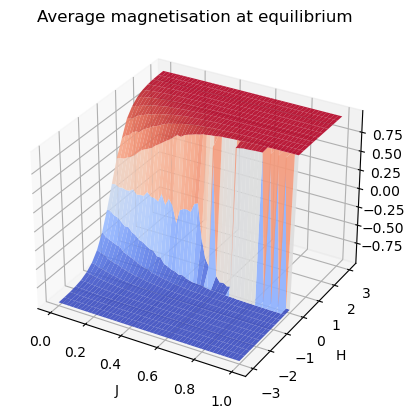

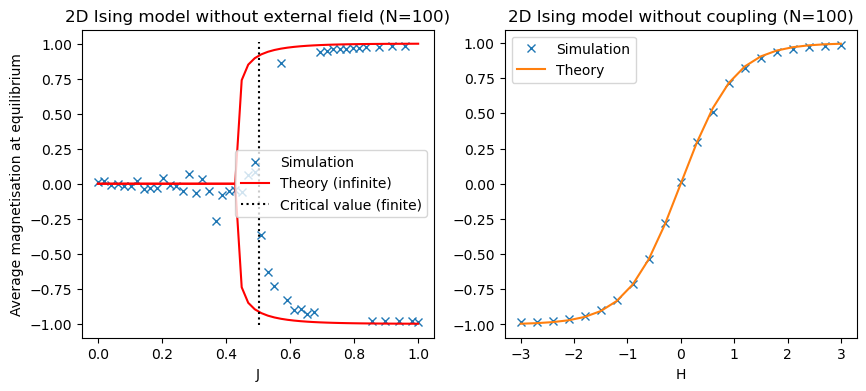

In [43]:
# parameters
L = 10
n_sims = 10**4

# values to loop over
J_arr = np.linspace(0,1,50)
H_arr = np.linspace(-3,3,21)

J_plot, H_plot = np.meshgrid(J_arr,H_arr)
#exact = np.sinh(H_plot)/(np.sqrt(np.sinh(H_plot)**2 + np.exp(-4*J_plot)))

# store results
all_avg_act = np.zeros((J_arr.size,H_arr.size))

# perform Gillespie for various J and H
for i,J in enumerate(J_arr):
    for j,H in enumerate(H_arr):
        # obtain results
        all_states, waiting_times = gillespie_ising_2d(n_sims,L,J,H)
        avg_act = np.mean(all_states, axis=(1,2))
    
        # truncate
        all_avg_act[i,j] = np.mean(avg_act[n_sims//3:])
        
# show results
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(J_plot.T, H_plot.T, all_avg_act,cmap=plt.cm.coolwarm,alpha=0.9,label='Simulation')
#ax.plot_wireframe(J_plot, H_plot, exact, color='g',alpha=0.65,label='Theory')
ax.set_xlabel('J')
ax.set_ylabel('H')
ax.set_title('Average magnetisation at equilibrium')
plt.show()

# specific cases
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# plot average magnetisation as a function of J where H = 0
H0_idx = np.where(H_arr==0)[0][0]

# analytical result for infinite system
def m_exact(J,Jcrit):
    return np.piecewise(J, [J < Jcrit, J >= Jcrit], [0, lambda J: (1 - (np.sinh(2*J))**-4)**(1/8)])

# critical value for infinite system
Jcrit = 0.5*np.log(1+np.sqrt(2))

ax1.plot(J_arr,all_avg_act[:,H0_idx],'x',label='Simulation')
ax1.plot(J_arr,m_exact(J_arr,Jcrit),color='r',label='Theory (infinite)')
ax1.plot(J_arr,-m_exact(J_arr,Jcrit),color='r')
ax1.axvline(x=Jcrit/(1-1.25/L),ymin=0.04,ymax=0.96,linestyle=':',color='k',label='Critical value (finite)')
ax1.set_xlabel('J')
ax1.set_ylabel('Average magnetisation at equilibrium')
ax1.set_title(f'2D Ising model without external field (N={L**2})')
ax1.legend()

# case without coupling energy
ax2.plot(H_arr,all_avg_act[0,:],'x',label='Simulation')
ax2.plot(H_arr,np.tanh(H_arr),label='Theory')
ax2.set_title(f'2D Ising model without coupling (N={L**2})')
ax2.legend()
ax2.set_xlabel('H')

plt.show()

### Interpretation

**Problem**: it does not agree perfectly with theory, but I'm unsure how to interpret this in the light of finite versus infinite system size. Also, I think the theoretical result is taken as an ensemble average, whereas here we take a time-average. I guess that both should be identical if the system is ergodic and at equilibrium, but perhaps this causes a discrepancy. By the way, I don't think an ensemble average is feasible, because then the left figure will just show 0 on avarage (so perhaps taking an ensemble average of the absolute value would be better?)

# Comparison to Keegstra et al. 

Having verified that our simulation reproduces basic properties of the Ising model, we now focus on reproducing some of the results by Keegstra et al. They apply the 2D Ising model in the context of receptor cluster activity. Concretely, each of the $L^2$ lattice sites now represents an allosteric unit that can switch between an active and inactive conformational state. While the Ising model works with spin variables, which take values $\pm 1$, it is convenient to interpret our results as activity variables, which take values $0$ or $1$. We achieve this mapping straightforwardly as 

$$ a_i = \frac{1}{2} + \frac{1}{2}s_i, $$

where $a_i$ is the activity of the $i$th unit. Note that this mapping does not change the physics of the model, but it is merely a convention that makes comparing our simulation to experiments more straightforward.

Do note that interpreting the parameters of the Ising model is not per se trivial in this context. The coupling constant $J$ may represent the amount of cooperativity between the single allosteric units. In fact, in the case where $J\rightarrow \infty$, the phenomenology of the model is the MWC model. The external field $H$ is more ambiguous, as it may have several contributions. For instance, Keegstra et al. use it to capture effects of ligand binding on cluster activity as well as quantifying some 'activity bias' in individual cells. Therefore, we are careful with mapping $H$ to any biochemical reality, but rather take it as a modelling parameter that we can control to extract certain behaviour from our simulations.  

**Question**: if I understand correctly, Keegstra et al. take one lattice for the entire cell, so they assume there is one big cluster of receptors. Perhaps it is worth exploring later on whether we can relax this assumption and take an ensemble average over $N_c$ independent $N=L^2$-sized clusters. Likely, this will affect the noise kernel heavily. 

### Rewriting the code in Numba

For performance reasons, we reimplement our algorithm in Numba, which leads to a roughly 20-fold increase in speed.

In [102]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i] = np.roll(state[i],1)
        right[i] = np.roll(state[i],-1)
        top[:,i] = np.roll(state[i],1)
        bottom[:,i] = np.roll(state[i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

In [103]:
# check how fast this goes
L = 10
state = np.random.choice([-1.,1.], L**2)
state = state.reshape((L,L))
J = 1
H = 1

%timeit rates_2d_numba(J,H,state)

The slowest run took 4.60 times longer than the fastest. This could mean that an intermediate result is being cached.
11.3 µs ± 8.73 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
@numba.jit(nopython=True)

def gillespie_ising_2d_numba(n_sims,state0,L,J,H):
    # initialise
    state = state0

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)

    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

In [105]:
# check how fast this goes
n_sims = 10**2
L = 10
J = 1
H = 1
state0 = np.random.choice([-1.,1.], L**2)
state0 = state0.reshape((L,L))

%timeit gillespie_ising_2d_numba(n_sims,state0,L,J,H)

604 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Activity switching

**PROBABLY DELETE THIS**

In their paper, Keegstra et al. focus on cells that exhibit activity switching. Concretely, this a type of dynamics where the average activity per allosteric unit is roughly 1 for an extended period of time until the cluster quickly transitions to an inactive state, where it remains for some time before switching to a mostly active state. Keegstra and colleagues captured this empirical finding using an Ising model that is poised to criticality. Specifically, they use the following parameters: $L=12$, $J=0.5$ and various values of $H$. 

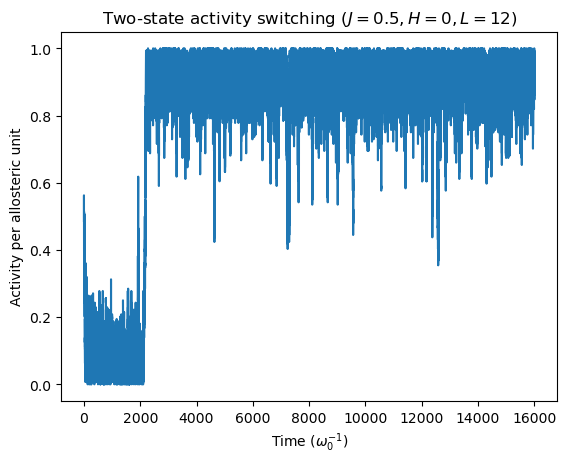

In [214]:
# simulate a time series
n_sims = 10**6
L = 12
J = 0.5
H = 0

# prepare initial state
state0 = np.random.choice([-1.,1.],L**2)
state0 = state0.reshape((L,L))

spins, waiting_times = gillespie_ising_2d_numba(n_sims,state0,L,J,H)

# map to activity
activity = 0.5 + 0.5*spins

# show activity per allosteric unit over time
act_unit = np.mean(activity, axis=(1,2))
time = np.cumsum(waiting_times)

plt.plot(time, act_unit)
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Activity per allosteric unit')
plt.title(f'Two-state activity switching $(J={J}, H={H}, L={L})$')
plt.show()

**REMOVE THIS** 

Below follows my attempt to automatically extract the transition and residence times. The steps are as follows:

- obtain time series
- make smoother by taking a moving average
- take 'derivative' (first difference) of filtered data
- identify a transition as points where the filtered data is more extreme than a few times the standard deviation of the difference
- extract indices corresponding to a transition; use these indices as well to identify plateaus (though not sure whether fair to assume that the activity always switches or sometimes is indifferent before moving on)
- extract transition and residence time scales

This sounds easier than it is, because it is hard to distinguish between two separate switching events. Is this a result we want to reproduce? Or rather focus on how the model responds to external stimuli?

6.07 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


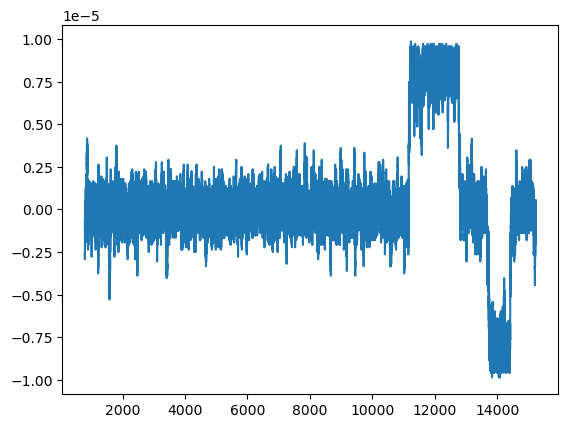

In [145]:
def moving_avg(arr,k):
    # take cumulative over k entries
    cumu = np.cumsum(arr)
    cumu[k:] = cumu[k:] - cumu[:-k] 
    
    # return average over window of size k
    return cumu[k-1:]/k

# check that this is reasonably fast
%timeit moving_avg(act_unit,5000)

test = moving_avg(act_unit,10**5)
test_time = moving_avg(time,10**5)

#plt.plot(test_time, test)
plt.plot(test_time[:-1], np.diff(test))
plt.show()

35116


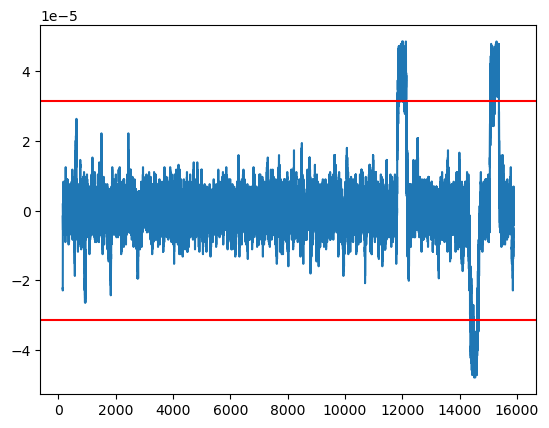

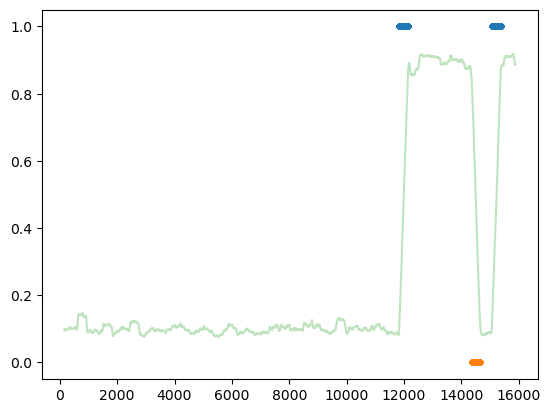

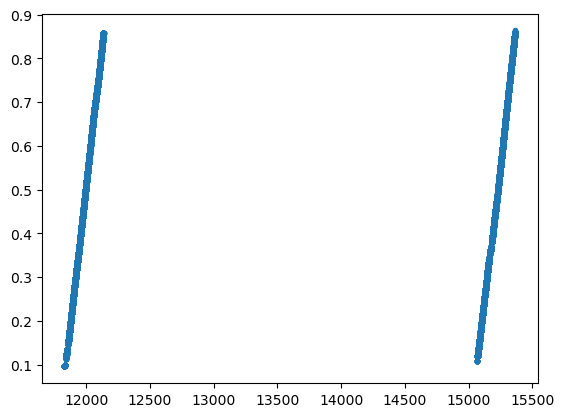

In [205]:
test = moving_avg(act_unit,2*10**4)
test_time = moving_avg(time,2*10**4)

base = np.mean(np.diff(test))
sd = np.std(np.diff(test))

rise_mask = np.diff(test) > 3*sd
fall_mask = np.diff(test) < -3*sd
#rise_idx = np.where(rise_mask == True)[0]

print(rise_mask.sum())

plt.plot(test_time[:-1], np.diff(test))
plt.axhline(y=3*sd,xmin=0,xmax=1,color='r')
plt.axhline(y=-3*sd,xmin=0,xmax=1,color='r')
plt.show()

check_rise = np.ones_like(test[:-1])

plt.plot(test_time[:-1][rise_mask], check_rise[rise_mask],'.')
plt.plot(test_time[:-1][fall_mask], 1-check_rise[fall_mask],'.')
plt.plot(test_time, test, alpha=0.3)

plt.show()

plt.plot(test_time[:-1][rise_mask], test[:-1][rise_mask],'.')

In [183]:
np.r_[~rise_mask[0],rise_mask]

array([ True, False, False, ..., False, False, False])

[  10336.45299752   10336.37481939 4063756.94565679]
[   26027.71359913    26027.62002762 10425142.21933234]


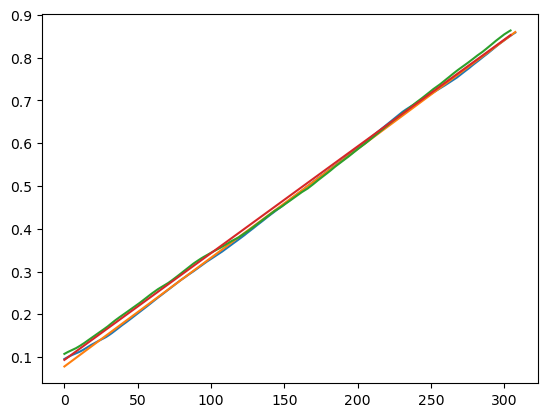

In [213]:
# define model function
def exp_fit(t,a,b,tau):
    return a - b*np.exp(-t/tau)

rise_indices = np.flatnonzero(np.diff(np.r_[~rise_mask[0],rise_mask]))[1:]

partition_rise = np.argwhere(np.diff(rise_indices) > 10**4).flatten()

rise_ends = rise_indices[partition_rise]
begin = 0

for i in range(np.size(partition_rise) + 1):
    if i == np.size(partition_rise):
        end = -1
    else:
        end = partition_rise[i]
        
    t = test_time[rise_indices[begin]:rise_indices[end]]
    rise_data = test[rise_indices[begin]:rise_indices[end]]
    
    popt, pcov = curve_fit(exp_fit,t-t[0],rise_data)
    plt.plot(t-t[0],rise_data)
    plt.plot(t-t[0],exp_fit(t-t[0],*popt))
    
    print(popt)

    begin = end + 1
    
